In [1]:
from Funcs.Utility import *

In [2]:
p = os.path.join(PATH_INTERMEDIATE, 'calorie_count_binary_personal-15min.pkl')
X, y, groups, t, datetimes = load(p)

In [3]:
#Divide the features into different categories
feat_current = X.loc[:,[('#VAL' in str(x)) or ('ESM#LastLabel' in str(x)) for x in X.keys()]]  
feat_dsc = X.loc[:,[('#DSC' in str(x))  for x in X.keys()]]  
feat_yesterday = X.loc[:,[('Yesterday' in str(x))  for x in X.keys()]]  
feat_today = X.loc[:,[('Today' in str(x))  for x in X.keys()]]  
feat_sleep = X.loc[:,[('Sleep' in str(x))  for x in X.keys()]]  
feat_time = X.loc[:,[('Time' in str(x))  for x in X.keys()]]  
feat_pif = X.loc[:,[('PIF' in str(x))  for x in X.keys()]]  
feat_ImmediatePast = X.loc[:,[('ImmediatePast_15' in str(x))  for x in X.keys()]]
#Divide the time window features into sensor/past stress label
feat_current_sensor = X.loc[:,[('#VAL' in str(x))  for x in X.keys()]]  
feat_current_ESM = X.loc[:,[('ESM#LastLabel' in str(x)) for x in X.keys()]]  
feat_ImmediatePast_sensor = feat_ImmediatePast.loc[:,[('ESM' not in str(x)) for x in feat_ImmediatePast.keys()]]  
feat_ImmediatePast_ESM = feat_ImmediatePast.loc[:,[('ESM'  in str(x)) for x in feat_ImmediatePast.keys()]]  
feat_today_sensor = feat_today.loc[:,[('ESM' not in str(x))  for x in feat_today.keys()]]  
feat_today_ESM = feat_today.loc[:,[('ESM'  in str(x)) for x in feat_today.keys()]]  
feat_yesterday_sensor = feat_yesterday.loc[:,[('ESM' not in str(x)) for x in feat_yesterday.keys()]]  
feat_yesterday_ESM = feat_yesterday.loc[:,[('ESM'  in str(x)) for x in feat_yesterday.keys()]]

In [4]:
feat_baseline = pd.concat([ feat_time,feat_dsc,feat_current_sensor, feat_ImmediatePast_sensor],axis=1)
feat_final = pd.concat([feat_baseline  ], axis=1)
# # Fill NaN values with zeros
feat_final = feat_final.fillna(0)
X = feat_final
cats = X.columns[X.dtypes == bool]

In [5]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score, classification_report

In [6]:
from sklearn.metrics import roc_auc_score
import pandas as pd
from sklearn.model_selection import LeaveOneGroupOut
import xgboost as xgb

logo = LeaveOneGroupOut()
# To store the AUC for each user
user_auc_scores = []

for train_index, test_index in logo.split(X, y, groups=groups):
    # Splitting the data based on user groups
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]  # Use iloc for row indexing
    y_train, y_test = y[train_index], y[test_index]
    group_test = groups[test_index]  # Groups of test data

    # Create DMatrix for XGBoost
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    # Set up the XGBoost model
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'eta': 0.1,
        'max_depth': 6,
        'seed': 42
    }

    # Train the model
    model = xgb.train(params, dtrain, num_boost_round=100)

    # Make predictions
    y_pred = model.predict(dtest)

    # Calculate AUC
    try:
        auc = roc_auc_score(y_test, y_pred)
        print(f"User {group_test[0]} AUC: {auc}")
    except ValueError:
        # Handle case where only one class is present in y_test (cannot calculate AUC)
        auc = 0
        print(f"User {group_test[0]} AUC: Unable to calculate AUC due to single class in y_test")

    # Store the PID and its AUC score
    user_auc_scores.append((group_test[0], auc))

# Convert the results into a DataFrame to make sorting easier
user_auc_df = pd.DataFrame(user_auc_scores, columns=['PID', 'AUC'])

# IQR Method to find outliers
Q1 = user_auc_df['AUC'].quantile(0.25)
Q3 = user_auc_df['AUC'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower bound for outliers
lower_bound = Q1 - 1.5 * IQR

# Identify users with AUCs below the lower bound
lowest_performing_users = user_auc_df[user_auc_df['AUC'] < lower_bound]

# Display the lowest-performing users
print("Lowest performing users based on IQR method:")
print(lowest_performing_users) 

User P001 AUC: 0.7450155073105893
User P002 AUC: 0.745308136892006
User P003 AUC: 0.7846989966555183
User P007 AUC: 0.7823541932737335
User P008 AUC: 0.752127659574468
User P009 AUC: 0.6524159663865546
User P010 AUC: 0.8508666345690901
User P011 AUC: 0.7936879432624114
User P013 AUC: 0.7032774390243903
User P014 AUC: 0.6651069518716578
User P015 AUC: 0.7838332752005581
User P016 AUC: 0.8054970760233918
User P018 AUC: 0.6913349917081261
User P019 AUC: 0.8728206514393837
User P020 AUC: 0.7094846900672143
User P021 AUC: 0.6873591989987484
User P022 AUC: 0.6869565217391306
User P023 AUC: 0.7698250186150409
User P024 AUC: 0.7525443786982249
User P025 AUC: 0.8256272401433692
User P026 AUC: 0.8666817053913828
User P027 AUC: 0.7650809716599191
User P028 AUC: 0.8010545267489712
User P029 AUC: 0.7656491926564919
User P030 AUC: 0.7310038340885326
User P033 AUC: 0.6808488175675674
User P034 AUC: 0.7497435897435898
User P035 AUC: 0.7267441860465116
User P037 AUC: 0.8013455657492355
User P038 AUC: 0

In [7]:
# Define the lower bound for outliers
lower_bound = Q1 - 1 * IQR

# Identify users with AUCs below the lower bound
lowest_performing_users = user_auc_df[user_auc_df['AUC'] < lower_bound]

# Display the lowest-performing users
print("Lowest performing users based on IQR method:")
print(lowest_performing_users) 

Lowest performing users based on IQR method:
      PID       AUC
32   P042  0.612500
34   P044  0.650513
40   P050  0.539001
64   P079  0.541054
80   P101  0.632114
96   P121  0.649597
102  P127  0.598321


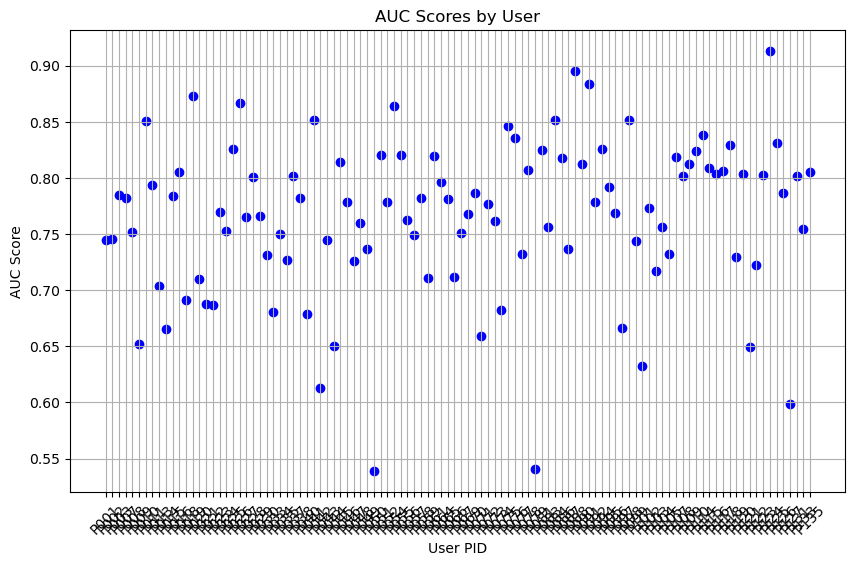

In [8]:
import matplotlib.pyplot as plt

pids, auc_scores = zip(*user_auc_scores)
plt.figure(figsize=(10, 6))
plt.scatter(pids, auc_scores, color='blue')

# Add labels and title
plt.xlabel('User PID')
plt.ylabel('AUC Score')
plt.title('AUC Scores by User')

# Optionally, add a grid for better readability
plt.grid(True)

# Show the plot
plt.xticks(rotation=45)  
plt.show()

In [9]:
import pandas as pd

# Assuming X is your DataFrame

# List of prefixes to filter
prefixes = ['SCR', 'PWR', 'CHG', 'BAT', 'LOC']

# Filter columns based on the prefixes
filtered_columns = [col for col in X.columns if any(col.startswith(prefix) for prefix in prefixes)]

# Create a new DataFrame with the filtered columns
filtered_df = X[filtered_columns]

X_fil = filtered_df

In [10]:
X_fil = X_fil[[col for col in X_fil.columns if not col.endswith('#ImmediatePast_15')]]

In [11]:
cn = X_fil.columns.tolist()
print(cn)

['BAT_STA#DSC', 'BAT_STA#DSC=DISCHARGINGCHARGINGFULLNOT_CHARGING', 'BAT_PLG#DSC', 'BAT_PLG#DSC=UNDEFINEDACUSBWIRELESS', 'LOC_LABEL#DSC', 'LOC_LABEL#DSC=noneworkhome', 'SCR_EVENT#DSC', 'SCR_EVENT#DSC=SCREEN_OFFSCREEN_ONUSER_PRESENT', 'CHG#DSC', 'CHG#DSC=DISCONNECTED', 'CHG#DSC=CONNECTED', 'PWR#DSC', 'PWR#DSC=ACTIVATE', 'PWR#DSC=DEACTIVATE', 'BAT_LEV#VAL', 'BAT_STA#VAL=DISCHARGINGCHARGINGFULLNOT_CHARGING', 'BAT_TMP#VAL', 'BAT_PLG#VAL=UNDEFINEDACUSBWIRELESS', 'LOC_LABEL#VAL=noneworkhome', 'SCR_EVENT#VAL=SCREEN_OFFSCREEN_ONUSER_PRESENT', 'SCR_DUR#VAL', 'CHG#VAL=DISCONNECTED', 'CHG#VAL=CONNECTED', 'PWR#VAL=ACTIVATE', 'PWR#VAL=DEACTIVATE']


In [12]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# # Assuming the sorted_user_auc_df contains the sorted PIDs with their AUC
# lowest_performing_pids = sorted_user_auc_df['PID'].head(5).values

# # Create a DataFrame for the low-performing and high-performing users using the groups array
# X_low = X[np.isin(groups, lowest_performing_pids)]
# X_high = X[~np.isin(groups, lowest_performing_pids)]

# # Function to compare trends for each feature
# def analyze_feature_trends(cn, X_low, X_high):
#     for feature in cn:
#         print(f"\nAnalyzing Feature: {feature}")
        
#         # Check if the feature is in X
#         if feature not in X.columns:
#             print(f"Feature {feature} not found in dataset!")
#             continue
        
#         # Separate the feature values for low and high-performing users
#         low_vals = X_low[feature]
#         high_vals = X_high[feature]

#         # If the feature is numeric, compare means
#         if np.issubdtype(low_vals.dtype, np.number):
#             low_mean = low_vals.mean()
#             high_mean = high_vals.mean()
#             print(f"Low-performing Mean: {low_mean}, High-performing Mean: {high_mean}")
            
#             # Plot the distribution for both
#             plt.figure(figsize=(10, 6))
#             plt.hist(low_vals, bins=30, alpha=0.5, label='Low-performing', color='red')
#             plt.hist(high_vals, bins=30, alpha=0.5, label='High-performing', color='blue')
#             plt.title(f'Distribution of {feature}')
#             plt.legend()
#             plt.show()
        
#         # If the feature is categorical, compare value counts
#         else:
#             low_counts = low_vals.value_counts(normalize=True)
#             high_counts = high_vals.value_counts(normalize=True)
#             comparison = pd.DataFrame({'Low-performing': low_counts, 'High-performing': high_counts}).fillna(0)
#             print(comparison)
            
#             # Plot the comparison
#             comparison.plot(kind='bar', figsize=(10, 6), title=f'{feature} Comparison')
#             plt.show()

# # Apply the analysis to the feature list
# analyze_feature_trends(cn, X_low, X_high)


In [13]:
!pip install slicer

correlation

Training XGBoost for low-performing users...
Training XGBoost for high-performing users...
Feature Importance Comparison between Low and High Performing Users using SHAP:
                                    Feature  Importance_low  Importance_high  \
154          DATA_MSNT#BEP#ImmediatePast_15        0.332615         0.017644   
224  Notification_CAT#ETP##ImmediatePast_15        0.156380         0.013856   
213     BT_DeviceType#ASC##ImmediatePast_15        0.122648         0.011701   
23                             CALL_CNT#DSC        0.149962         0.074133   
34                         BT_BondState#DSC        0.095011         0.021282   
..                                      ...             ...              ...   
202            SCR_DUR#TSC#ImmediatePast_15        0.055260         0.130141   
150          DATA_MSNT#STD#ImmediatePast_15        0.028924         0.141124   
142          DATA_MRCV#STD#ImmediatePast_15        0.035638         0.161089   
54                           

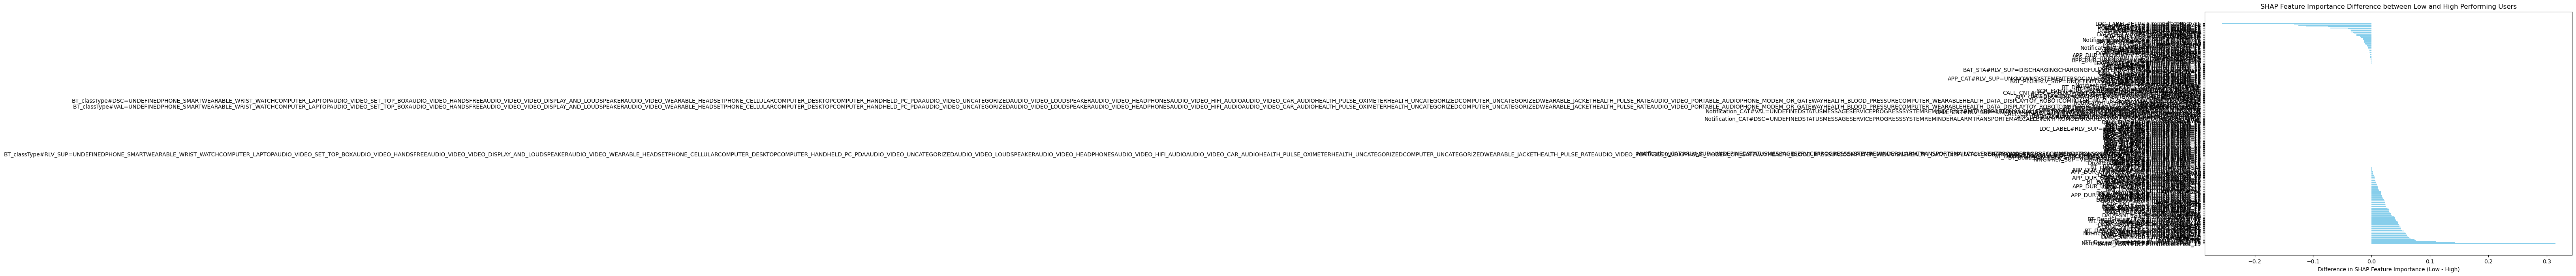

In [14]:
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import matplotlib.pyplot as plt

# Assuming the sorted_user_auc_df contains the sorted PIDs with their AUC
lowest_performing_pids = lowest_performing_users['PID']

# Create a DataFrame for the low-performing and high-performing users using the groups array
X_low = X[np.isin(groups, lowest_performing_pids)]
X_high = X[~np.isin(groups, lowest_performing_pids)]

y_low = y[np.isin(groups, lowest_performing_pids)]
y_high = y[~np.isin(groups, lowest_performing_pids)]

# Create DMatrix for low and high-performing users
dtrain_low = xgb.DMatrix(X_low, label=y_low)
dtrain_high = xgb.DMatrix(X_high, label=y_high)

# Set up common XGBoost parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.1,
    'max_depth': 6
}

# Train the model for low-performing users
print("Training XGBoost for low-performing users...")
model_low = xgb.train(params, dtrain_low, num_boost_round=100)

# Train the model for high-performing users
print("Training XGBoost for high-performing users...")
model_high = xgb.train(params, dtrain_high, num_boost_round=100)

# Initialize the SHAP explainer for both models
explainer_low = shap.TreeExplainer(model_low)
explainer_high = shap.TreeExplainer(model_high)

# Calculate SHAP values for the features in both low and high-performing groups
shap_values_low = explainer_low.shap_values(X_low)
shap_values_high = explainer_high.shap_values(X_high)

# Calculate mean absolute SHAP values for each feature to get the feature importance
importance_low = np.abs(shap_values_low).mean(axis=0)
importance_high = np.abs(shap_values_high).mean(axis=0)

# Convert the SHAP values into a DataFrame for easy comparison
features = X_low.columns  # Assuming X_low and X_high have the same columns
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance_low': importance_low,
    'Importance_high': importance_high
})

# Calculate the difference in importance between low and high-performing users
importance_df['Importance_diff'] = importance_df['Importance_low'] - importance_df['Importance_high']

# Sort by the difference in importance
importance_df = importance_df.sort_values(by='Importance_diff', ascending=False)

# Display the top features that differ the most
print("Feature Importance Comparison between Low and High Performing Users using SHAP:")
print(importance_df)

# Plot the feature importance comparison using SHAP values
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance_diff'], color='skyblue')
plt.xlabel('Difference in SHAP Feature Importance (Low - High)')
plt.title('SHAP Feature Importance Difference between Low and High Performing Users')
plt.show()


In [15]:
# import pandas as pd
# import numpy as np
# import xgboost as xgb
# import matplotlib.pyplot as plt

# # Assuming the sorted_user_auc_df contains the sorted PIDs with their AUC
# lowest_performing_pids = sorted_user_auc_df['PID'].head(5).values

# # Create a DataFrame for the low-performing and high-performing users using the groups array
# X_low = X[np.isin(groups, lowest_performing_pids)]
# X_high = X[~np.isin(groups, lowest_performing_pids)]

# y_low = y[np.isin(groups, lowest_performing_pids)]
# y_high = y[~np.isin(groups, lowest_performing_pids)]

# # Create DMatrix for low and high-performing users
# dtrain_low = xgb.DMatrix(X_low, label=y_low)
# dtrain_high = xgb.DMatrix(X_high, label=y_high)

# # Set up common XGBoost parameters
# params = {
#     'objective': 'binary:logistic',
#     'eval_metric': 'logloss',
#     'eta': 0.1,
#     'max_depth': 6
# }

# # Train the model for low-performing users
# print("Training XGBoost for low-performing users...")
# model_low = xgb.train(params, dtrain_low, num_boost_round=100)

# # Train the model for high-performing users
# print("Training XGBoost for high-performing users...")
# model_high = xgb.train(params, dtrain_high, num_boost_round=100)

# # Get feature importance for both models
# importance_low = model_low.get_score(importance_type='weight')
# importance_high = model_high.get_score(importance_type='weight')

# # Convert the feature importance into a DataFrame for easy comparison
# importance_df_low = pd.DataFrame(list(importance_low.items()), columns=['Feature', 'Importance_low'])
# importance_df_high = pd.DataFrame(list(importance_high.items()), columns=['Feature', 'Importance_high'])

# # Merge both importance DataFrames to compare
# importance_df = pd.merge(importance_df_low, importance_df_high, on='Feature', how='outer').fillna(0)

# # Sort by the difference in importance
# importance_df['Importance_diff'] = importance_df['Importance_low'] - importance_df['Importance_high']
# importance_df = importance_df.sort_values(by='Importance_diff', ascending=False)

# # Display the top features that differ the most
# print("Feature Importance Comparison between Low and High Performing Users:")
# print(importance_df)

# # Plot the feature importance comparison
# plt.figure(figsize=(12, 8))
# plt.barh(importance_df['Feature'], importance_df['Importance_diff'], color='skyblue')
# plt.xlabel('Difference in Feature Importance (Low - High)')
# plt.title('Feature Importance Difference between Low and High Performing Users')
# plt.show()

In [16]:
importance_df = importance_df.sort_values(by='Importance_diff', ascending=True)
importance_df

,Feature,Importance_low,Importance_high,Importance_diff
165,LOC_LABEL#ETP##ImmediatePast_15,0.019861,0.276502,-0.256641
54,BAT_TMP#VAL,0.112114,0.244849,-0.132735
142,DATA_MRCV#STD#ImmediatePast_15,0.035638,0.161089,-0.125452
150,DATA_MSNT#STD#ImmediatePast_15,0.028924,0.141124,-0.112200
202,SCR_DUR#TSC#ImmediatePast_15,0.055260,0.130141,-0.074881
...,...,...,...,...
34,BT_BondState#DSC,0.095011,0.021282,0.073729
23,CALL_CNT#DSC,0.149962,0.074133,0.075830
213,BT_DeviceType#ASC##ImmediatePast_15,0.122648,0.011701,0.110947
224,Notification_CAT#ETP##ImmediatePast_15,0.156380,0.013856,0.142524


Descriptive Statistics for Low Performing Users:
Mean: 30.063966751098633, Median: 29.200000762939453, Std: 4.830642223358154, Min: 10.100000381469727, Max: 44.900001525878906

Descriptive Statistics for High Performing Users:
Mean: 30.248287200927734, Median: 30.299999237060547, Std: 4.646866798400879, Min: 4.0, Max: 48.599998474121094


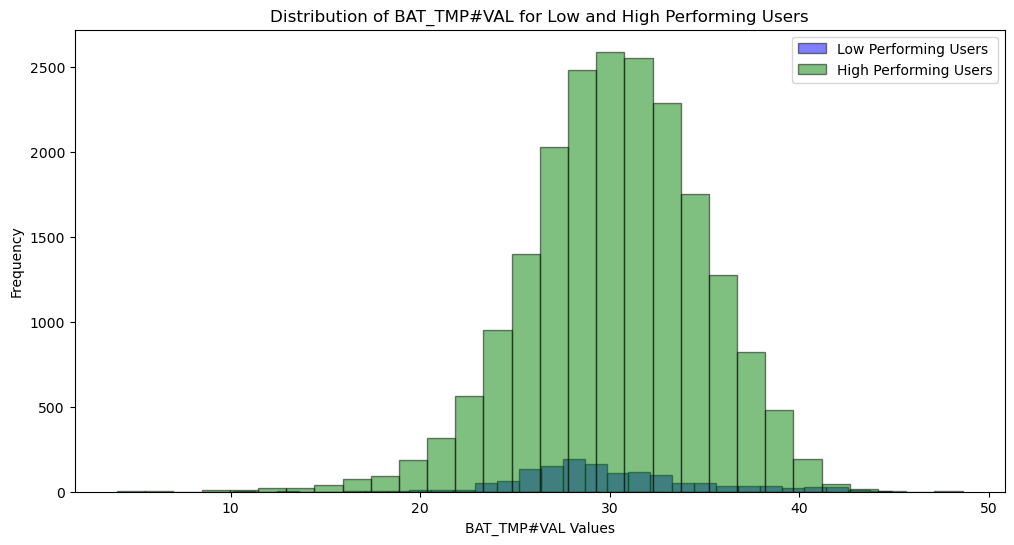

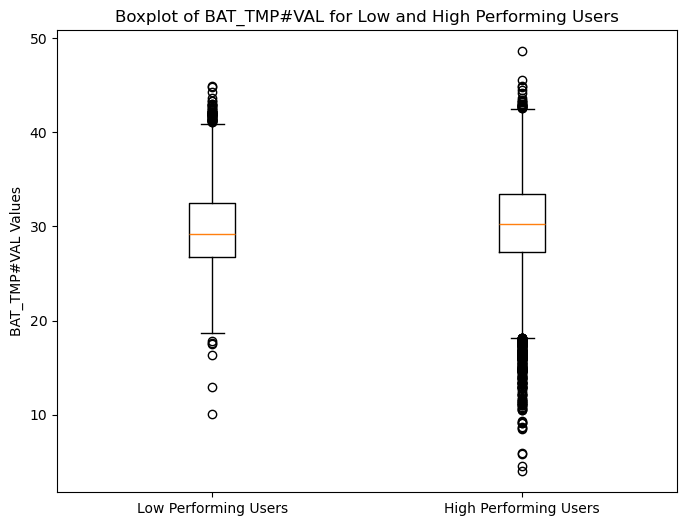

T-test results for BAT_TMP#VAL: t-statistic = -1.3868016076931637, p-value = 0.16569636364278206
Mann-Whitney U test results for BAT_TMP#VAL: U-statistic = 13122952.5, p-value = 1.2795128547370299e-06
Pearson correlation for low-performing users: -0.1166509408948029
Pearson correlation for high-performing users: -0.28174275641525576


In [17]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Extract the feature for low and high performing users
feature_name = 'BAT_TMP#VAL'
low_feature_values = X_low[feature_name]
high_feature_values = X_high[feature_name]

# 1. Descriptive statistics
print("Descriptive Statistics for Low Performing Users:")
print(f"Mean: {np.mean(low_feature_values)}, Median: {np.median(low_feature_values)}, Std: {np.std(low_feature_values)}, Min: {np.min(low_feature_values)}, Max: {np.max(low_feature_values)}")

print("\nDescriptive Statistics for High Performing Users:")
print(f"Mean: {np.mean(high_feature_values)}, Median: {np.median(high_feature_values)}, Std: {np.std(high_feature_values)}, Min: {np.min(high_feature_values)}, Max: {np.max(high_feature_values)}")

# 2. Visualize the distributions
plt.figure(figsize=(12, 6))
plt.hist(low_feature_values, bins=30, alpha=0.5, label='Low Performing Users', color='blue', edgecolor='black')
plt.hist(high_feature_values, bins=30, alpha=0.5, label='High Performing Users', color='green', edgecolor='black')
plt.xlabel(f"{feature_name} Values")
plt.ylabel("Frequency")
plt.title(f"Distribution of {feature_name} for Low and High Performing Users")
plt.legend()
plt.show()

# Boxplot for better visualization
plt.figure(figsize=(8, 6))
plt.boxplot([low_feature_values, high_feature_values], labels=['Low Performing Users', 'High Performing Users'])
plt.title(f"Boxplot of {feature_name} for Low and High Performing Users")
plt.ylabel(f"{feature_name} Values")
plt.show()

# 3. Statistical test (T-test or Mann-Whitney U test based on normality)
# If data is normally distributed use t-test; otherwise, Mann-Whitney U test
t_stat, p_val = stats.ttest_ind(low_feature_values, high_feature_values, equal_var=False)
print(f"T-test results for {feature_name}: t-statistic = {t_stat}, p-value = {p_val}")

# Alternatively, if not normally distributed:
u_stat, p_val_u = stats.mannwhitneyu(low_feature_values, high_feature_values)
print(f"Mann-Whitney U test results for {feature_name}: U-statistic = {u_stat}, p-value = {p_val_u}")

# 4. Correlation with the target for each group
pearson_corr_low = np.corrcoef(low_feature_values, y_low)[0, 1]
pearson_corr_high = np.corrcoef(high_feature_values, y_high)[0, 1]
print(f"Pearson correlation for low-performing users: {pearson_corr_low}")
print(f"Pearson correlation for high-performing users: {pearson_corr_high}")


Descriptive Statistics for Low Performing Users:
Mean: 5526557.5, Median: 11969.400390625, Std: 43537820.0, Min: 0.0, Max: 960745024.0

Descriptive Statistics for High Performing Users:
Mean: 22398414.0, Median: 4173.4248046875, Std: 257894256.0, Min: 0.0, Max: 17760813056.0


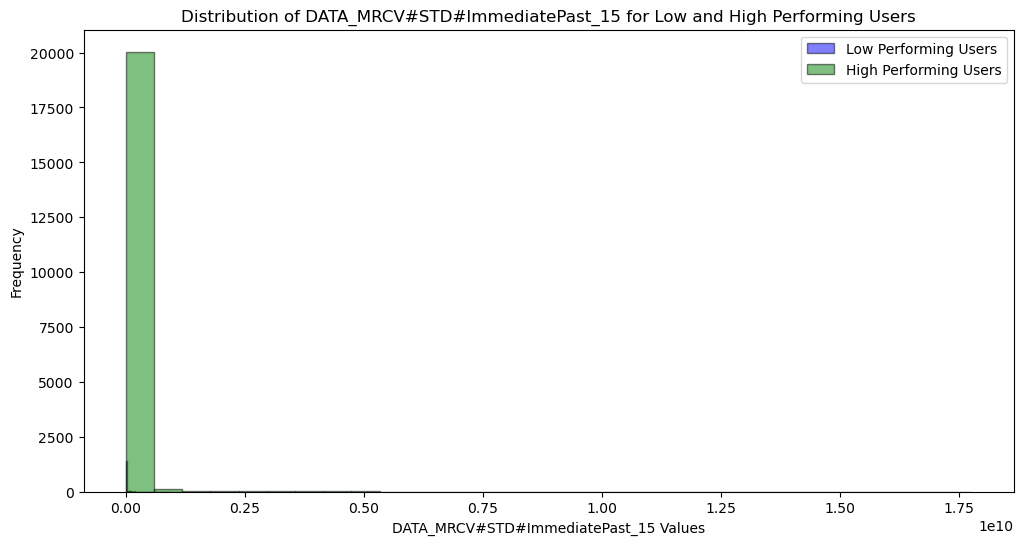

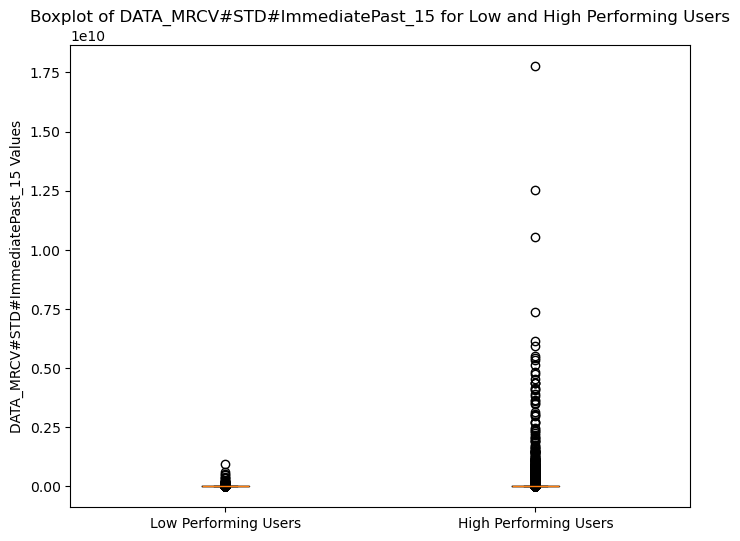

T-test results for DATA_MRCV#STD#ImmediatePast_15: t-statistic = -7.8335289532341665, p-value = 5.1505366610858955e-15
Mann-Whitney U test results for DATA_MRCV#STD#ImmediatePast_15: U-statistic = 14133823.5, p-value = 0.7058040114539512
Pearson correlation for low-performing users: 0.030393891671217747
Pearson correlation for high-performing users: 0.04296499387545505


In [18]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Extract the feature for low and high performing users
feature_name = 'DATA_MRCV#STD#ImmediatePast_15'
low_feature_values = X_low[feature_name]
high_feature_values = X_high[feature_name]

# 1. Descriptive statistics
print("Descriptive Statistics for Low Performing Users:")
print(f"Mean: {np.mean(low_feature_values)}, Median: {np.median(low_feature_values)}, Std: {np.std(low_feature_values)}, Min: {np.min(low_feature_values)}, Max: {np.max(low_feature_values)}")

print("\nDescriptive Statistics for High Performing Users:")
print(f"Mean: {np.mean(high_feature_values)}, Median: {np.median(high_feature_values)}, Std: {np.std(high_feature_values)}, Min: {np.min(high_feature_values)}, Max: {np.max(high_feature_values)}")

# 2. Visualize the distributions
plt.figure(figsize=(12, 6))
plt.hist(low_feature_values, bins=30, alpha=0.5, label='Low Performing Users', color='blue', edgecolor='black')
plt.hist(high_feature_values, bins=30, alpha=0.5, label='High Performing Users', color='green', edgecolor='black')
plt.xlabel(f"{feature_name} Values")
plt.ylabel("Frequency")
plt.title(f"Distribution of {feature_name} for Low and High Performing Users")
plt.legend()
plt.show()

# Boxplot for better visualization
plt.figure(figsize=(8, 6))
plt.boxplot([low_feature_values, high_feature_values], labels=['Low Performing Users', 'High Performing Users'])
plt.title(f"Boxplot of {feature_name} for Low and High Performing Users")
plt.ylabel(f"{feature_name} Values")
plt.show()

# 3. Statistical test (T-test or Mann-Whitney U test based on normality)
# If data is normally distributed use t-test; otherwise, Mann-Whitney U test
t_stat, p_val = stats.ttest_ind(low_feature_values, high_feature_values, equal_var=False)
print(f"T-test results for {feature_name}: t-statistic = {t_stat}, p-value = {p_val}")

# Alternatively, if not normally distributed:
u_stat, p_val_u = stats.mannwhitneyu(low_feature_values, high_feature_values)
print(f"Mann-Whitney U test results for {feature_name}: U-statistic = {u_stat}, p-value = {p_val_u}")

# 4. Correlation with the target for each group
pearson_corr_low = np.corrcoef(low_feature_values, y_low)[0, 1]
pearson_corr_high = np.corrcoef(high_feature_values, y_high)[0, 1]
print(f"Pearson correlation for low-performing users: {pearson_corr_low}")
print(f"Pearson correlation for high-performing users: {pearson_corr_high}")


Descriptive Statistics for Low Performing Users:
Mean: 636585.5, Median: 11149.7333984375, Std: 3958676.5, Min: 0.0, Max: 78922576.0

Descriptive Statistics for High Performing Users:
Mean: 1922841.0, Median: 2258.86572265625, Std: 15718697.0, Min: 0.0, Max: 1101061632.0


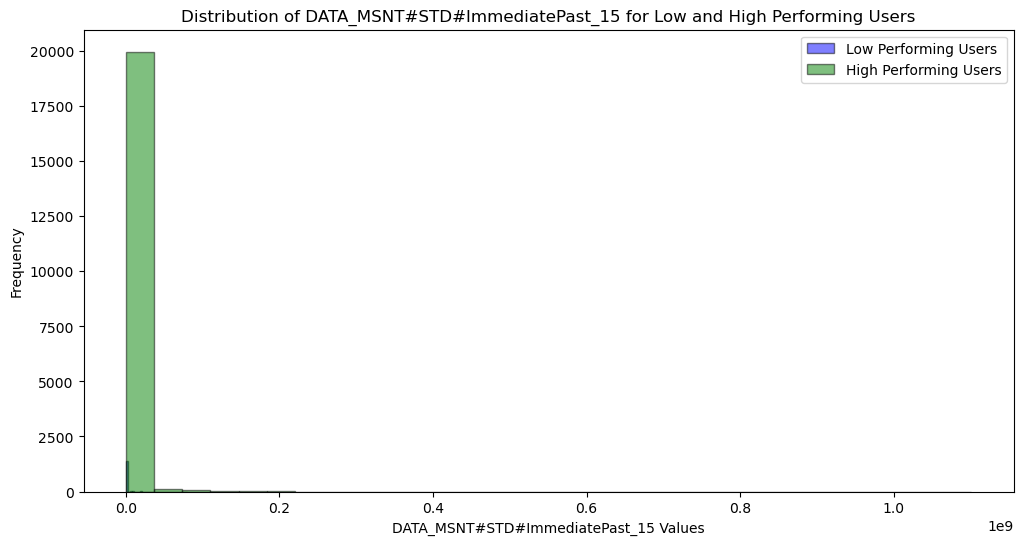

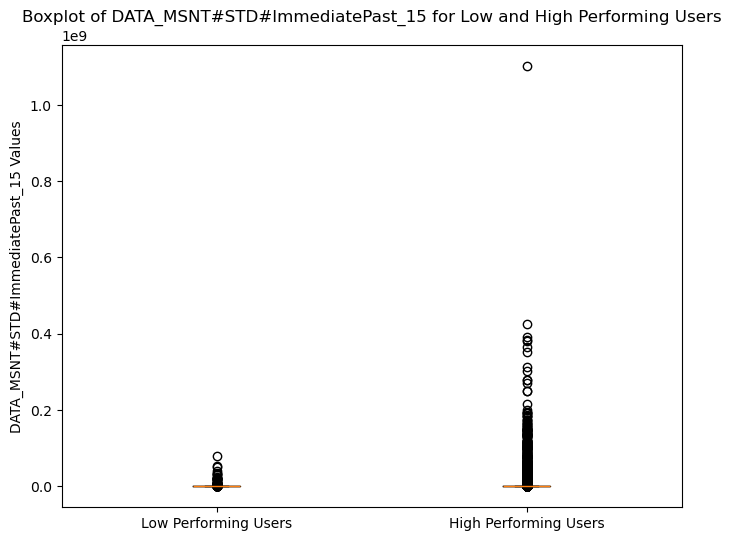

T-test results for DATA_MSNT#STD#ImmediatePast_15: t-statistic = -8.413447194975724, p-value = 4.980430200712284e-17
Mann-Whitney U test results for DATA_MSNT#STD#ImmediatePast_15: U-statistic = 14013856.0, p-value = 0.3637501614816664
Pearson correlation for low-performing users: 0.005587316089551953
Pearson correlation for high-performing users: 0.05831538335115237


In [19]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Extract the feature for low and high performing users
feature_name = 'DATA_MSNT#STD#ImmediatePast_15'
low_feature_values = X_low[feature_name]
high_feature_values = X_high[feature_name]

# 1. Descriptive statistics
print("Descriptive Statistics for Low Performing Users:")
print(f"Mean: {np.mean(low_feature_values)}, Median: {np.median(low_feature_values)}, Std: {np.std(low_feature_values)}, Min: {np.min(low_feature_values)}, Max: {np.max(low_feature_values)}")

print("\nDescriptive Statistics for High Performing Users:")
print(f"Mean: {np.mean(high_feature_values)}, Median: {np.median(high_feature_values)}, Std: {np.std(high_feature_values)}, Min: {np.min(high_feature_values)}, Max: {np.max(high_feature_values)}")

# 2. Visualize the distributions
plt.figure(figsize=(12, 6))
plt.hist(low_feature_values, bins=30, alpha=0.5, label='Low Performing Users', color='blue', edgecolor='black')
plt.hist(high_feature_values, bins=30, alpha=0.5, label='High Performing Users', color='green', edgecolor='black')
plt.xlabel(f"{feature_name} Values")
plt.ylabel("Frequency")
plt.title(f"Distribution of {feature_name} for Low and High Performing Users")
plt.legend()
plt.show()

# Boxplot for better visualization
plt.figure(figsize=(8, 6))
plt.boxplot([low_feature_values, high_feature_values], labels=['Low Performing Users', 'High Performing Users'])
plt.title(f"Boxplot of {feature_name} for Low and High Performing Users")
plt.ylabel(f"{feature_name} Values")
plt.show()

# 3. Statistical test (T-test or Mann-Whitney U test based on normality)
# If data is normally distributed use t-test; otherwise, Mann-Whitney U test
t_stat, p_val = stats.ttest_ind(low_feature_values, high_feature_values, equal_var=False)
print(f"T-test results for {feature_name}: t-statistic = {t_stat}, p-value = {p_val}")

# Alternatively, if not normally distributed:
u_stat, p_val_u = stats.mannwhitneyu(low_feature_values, high_feature_values)
print(f"Mann-Whitney U test results for {feature_name}: U-statistic = {u_stat}, p-value = {p_val_u}")

# 4. Correlation with the target for each group
pearson_corr_low = np.corrcoef(low_feature_values, y_low)[0, 1]
pearson_corr_high = np.corrcoef(high_feature_values, y_high)[0, 1]
print(f"Pearson correlation for low-performing users: {pearson_corr_low}")
print(f"Pearson correlation for high-performing users: {pearson_corr_high}")


In [20]:
importance_df.head(20)

,Feature,Importance_low,Importance_high,Importance_diff
165,LOC_LABEL#ETP##ImmediatePast_15,0.019861,0.276502,-0.256641
54,BAT_TMP#VAL,0.112114,0.244849,-0.132735
142,DATA_MRCV#STD#ImmediatePast_15,0.035638,0.161089,-0.125452
150,DATA_MSNT#STD#ImmediatePast_15,0.028924,0.141124,-0.112200
202,SCR_DUR#TSC#ImmediatePast_15,0.055260,0.130141,-0.074881
109,BAT_TMP#MED#ImmediatePast_15,0.013949,0.084268,-0.070318
199,SCR_DUR#ASC#ImmediatePast_15,0.013749,0.054572,-0.040823
153,DATA_MSNT#ASC#ImmediatePast_15,0.021132,0.057104,-0.035973
104,BAT_TMP#STD#ImmediatePast_15,0.103189,0.138850,-0.035661
12,Time#HRN=AFTERNOON,0.008103,0.042550,-0.034447


Descriptive Statistics for Low Performing Users:
Mean: 2.5488882064819336, Median: 2.4168853759765625, Std: 1.8109418153762817, Min: 0.0, Max: 12.754207611083984

Descriptive Statistics for High Performing Users:
Mean: 2.5417585372924805, Median: 2.3238131999969482, Std: 1.80778968334198, Min: 0.0, Max: 18.208240509033203


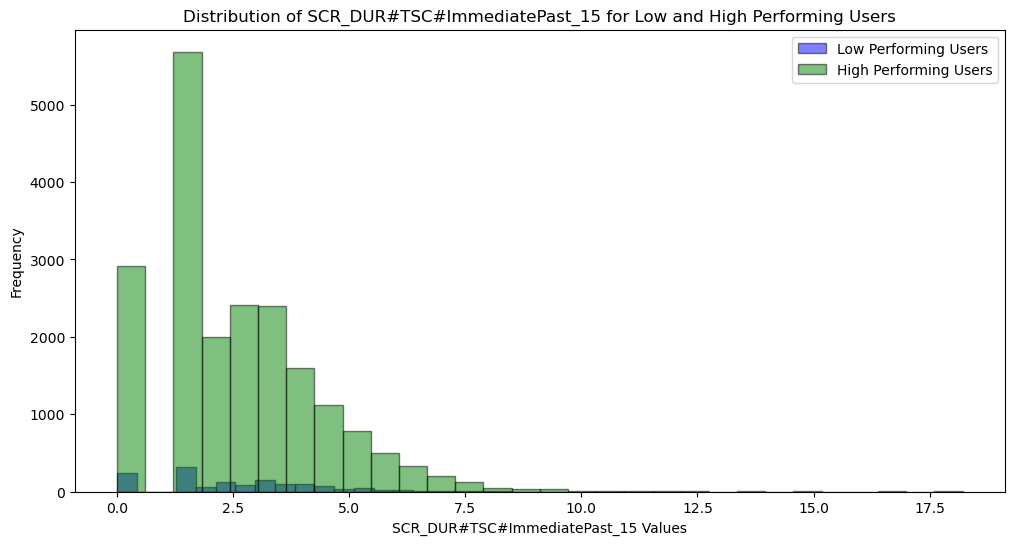

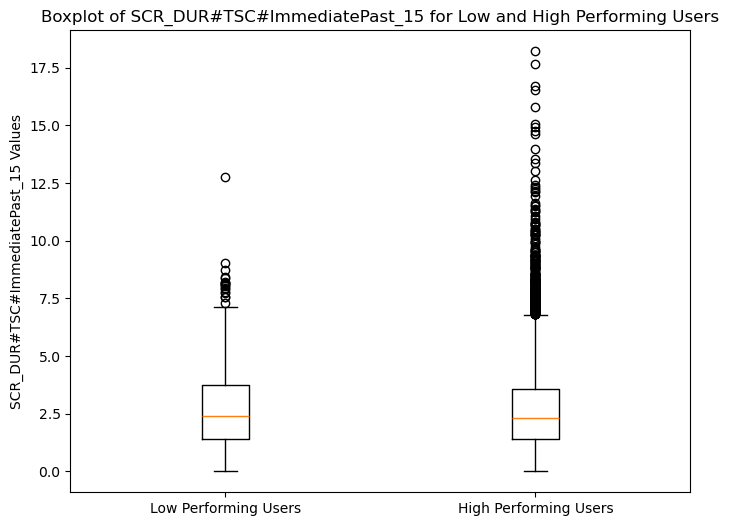

T-test results for SCR_DUR#TSC#ImmediatePast_15: t-statistic = 0.14275886764225837, p-value = 0.8864985178155982
Mann-Whitney U test results for SCR_DUR#TSC#ImmediatePast_15: U-statistic = 14333618.0, p-value = 0.6121685871442033
Pearson correlation for low-performing users: 0.14730058421626271
Pearson correlation for high-performing users: 0.28523996557381276


In [21]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Extract the feature for low and high performing users
feature_name = 'SCR_DUR#TSC#ImmediatePast_15'
low_feature_values = X_low[feature_name]
high_feature_values = X_high[feature_name]

# 1. Descriptive statistics
print("Descriptive Statistics for Low Performing Users:")
print(f"Mean: {np.mean(low_feature_values)}, Median: {np.median(low_feature_values)}, Std: {np.std(low_feature_values)}, Min: {np.min(low_feature_values)}, Max: {np.max(low_feature_values)}")

print("\nDescriptive Statistics for High Performing Users:")
print(f"Mean: {np.mean(high_feature_values)}, Median: {np.median(high_feature_values)}, Std: {np.std(high_feature_values)}, Min: {np.min(high_feature_values)}, Max: {np.max(high_feature_values)}")

# 2. Visualize the distributions
plt.figure(figsize=(12, 6))
plt.hist(low_feature_values, bins=30, alpha=0.5, label='Low Performing Users', color='blue', edgecolor='black')
plt.hist(high_feature_values, bins=30, alpha=0.5, label='High Performing Users', color='green', edgecolor='black')
plt.xlabel(f"{feature_name} Values")
plt.ylabel("Frequency")
plt.title(f"Distribution of {feature_name} for Low and High Performing Users")
plt.legend()
plt.show()

# Boxplot for better visualization
plt.figure(figsize=(8, 6))
plt.boxplot([low_feature_values, high_feature_values], labels=['Low Performing Users', 'High Performing Users'])
plt.title(f"Boxplot of {feature_name} for Low and High Performing Users")
plt.ylabel(f"{feature_name} Values")
plt.show()

# 3. Statistical test (T-test or Mann-Whitney U test based on normality)
# If data is normally distributed use t-test; otherwise, Mann-Whitney U test
t_stat, p_val = stats.ttest_ind(low_feature_values, high_feature_values, equal_var=False)
print(f"T-test results for {feature_name}: t-statistic = {t_stat}, p-value = {p_val}")

# Alternatively, if not normally distributed:
u_stat, p_val_u = stats.mannwhitneyu(low_feature_values, high_feature_values)
print(f"Mann-Whitney U test results for {feature_name}: U-statistic = {u_stat}, p-value = {p_val_u}")

# 4. Correlation with the target for each group
pearson_corr_low = np.corrcoef(low_feature_values, y_low)[0, 1]
pearson_corr_high = np.corrcoef(high_feature_values, y_high)[0, 1]
print(f"Pearson correlation for low-performing users: {pearson_corr_low}")
print(f"Pearson correlation for high-performing users: {pearson_corr_high}")


Descriptive Statistics for Low Performing Users:
Mean: 5526557.5, Median: 11969.400390625, Std: 43537820.0, Min: 0.0, Max: 960745024.0

Descriptive Statistics for High Performing Users:
Mean: 22398414.0, Median: 4173.4248046875, Std: 257894256.0, Min: 0.0, Max: 17760813056.0


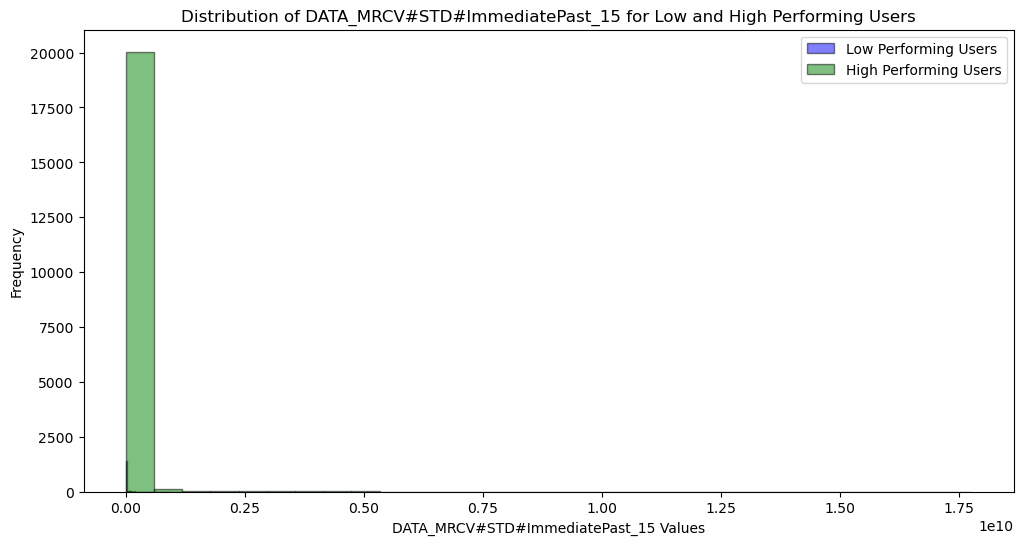

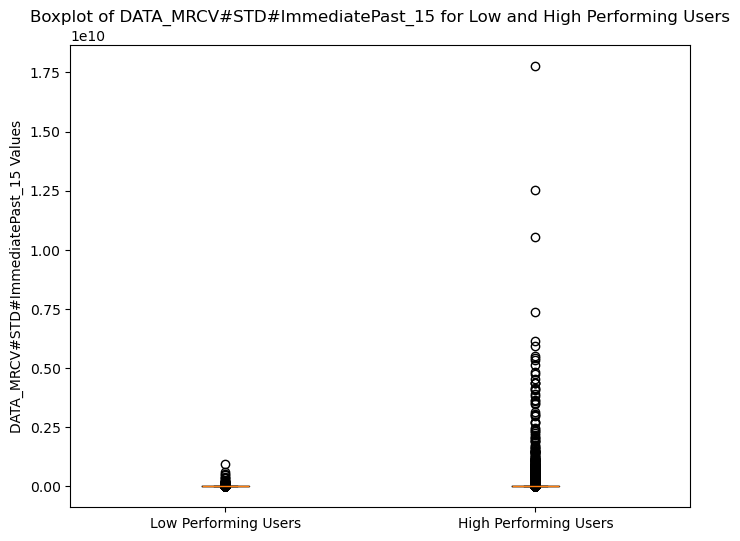

T-test results for DATA_MRCV#STD#ImmediatePast_15: t-statistic = -7.8335289532341665, p-value = 5.1505366610858955e-15
Mann-Whitney U test results for DATA_MRCV#STD#ImmediatePast_15: U-statistic = 14133823.5, p-value = 0.7058040114539512
Pearson correlation for low-performing users: 0.030393891671217747
Pearson correlation for high-performing users: 0.04296499387545505


In [22]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Extract the feature for low and high performing users
feature_name = 'DATA_MRCV#STD#ImmediatePast_15'
low_feature_values = X_low[feature_name]
high_feature_values = X_high[feature_name]

# 1. Descriptive statistics
print("Descriptive Statistics for Low Performing Users:")
print(f"Mean: {np.mean(low_feature_values)}, Median: {np.median(low_feature_values)}, Std: {np.std(low_feature_values)}, Min: {np.min(low_feature_values)}, Max: {np.max(low_feature_values)}")

print("\nDescriptive Statistics for High Performing Users:")
print(f"Mean: {np.mean(high_feature_values)}, Median: {np.median(high_feature_values)}, Std: {np.std(high_feature_values)}, Min: {np.min(high_feature_values)}, Max: {np.max(high_feature_values)}")

# 2. Visualize the distributions
plt.figure(figsize=(12, 6))
plt.hist(low_feature_values, bins=30, alpha=0.5, label='Low Performing Users', color='blue', edgecolor='black')
plt.hist(high_feature_values, bins=30, alpha=0.5, label='High Performing Users', color='green', edgecolor='black')
plt.xlabel(f"{feature_name} Values")
plt.ylabel("Frequency")
plt.title(f"Distribution of {feature_name} for Low and High Performing Users")
plt.legend()
plt.show()

# Boxplot for better visualization
plt.figure(figsize=(8, 6))
plt.boxplot([low_feature_values, high_feature_values], labels=['Low Performing Users', 'High Performing Users'])
plt.title(f"Boxplot of {feature_name} for Low and High Performing Users")
plt.ylabel(f"{feature_name} Values")
plt.show()

# 3. Statistical test (T-test or Mann-Whitney U test based on normality)
# If data is normally distributed use t-test; otherwise, Mann-Whitney U test
t_stat, p_val = stats.ttest_ind(low_feature_values, high_feature_values, equal_var=False)
print(f"T-test results for {feature_name}: t-statistic = {t_stat}, p-value = {p_val}")

# Alternatively, if not normally distributed:
u_stat, p_val_u = stats.mannwhitneyu(low_feature_values, high_feature_values)
print(f"Mann-Whitney U test results for {feature_name}: U-statistic = {u_stat}, p-value = {p_val_u}")

# 4. Correlation with the target for each group
pearson_corr_low = np.corrcoef(low_feature_values, y_low)[0, 1]
pearson_corr_high = np.corrcoef(high_feature_values, y_high)[0, 1]
print(f"Pearson correlation for low-performing users: {pearson_corr_low}")
print(f"Pearson correlation for high-performing users: {pearson_corr_high}")


Descriptive Statistics for Low Performing Users:
Mean: 636585.5, Median: 11149.7333984375, Std: 3958676.5, Min: 0.0, Max: 78922576.0

Descriptive Statistics for High Performing Users:
Mean: 1922841.0, Median: 2258.86572265625, Std: 15718697.0, Min: 0.0, Max: 1101061632.0


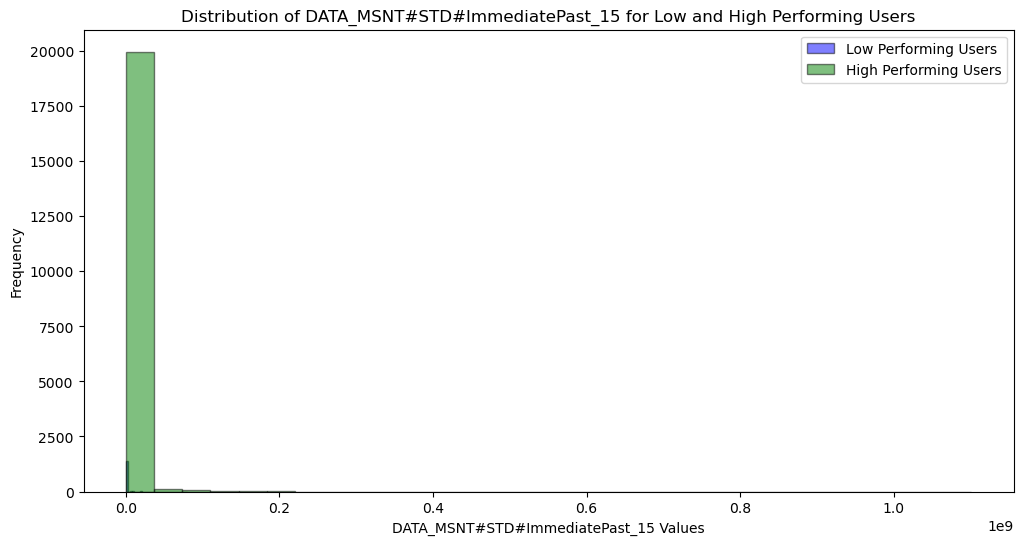

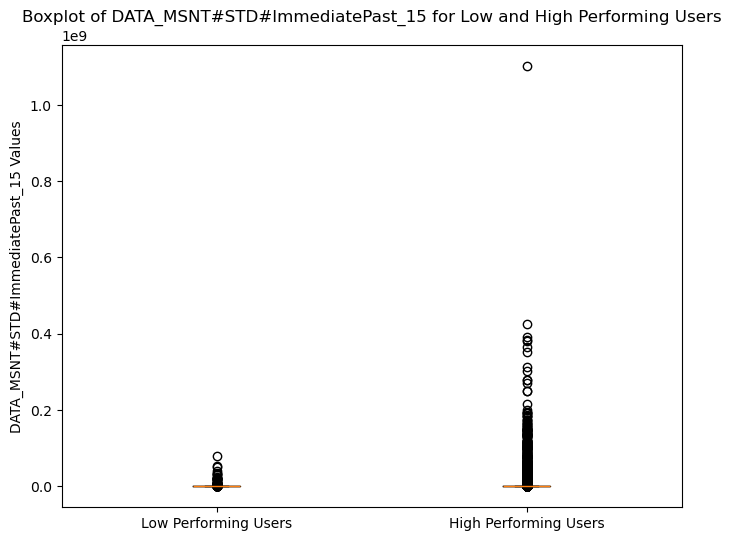

T-test results for DATA_MSNT#STD#ImmediatePast_15: t-statistic = -8.413447194975724, p-value = 4.980430200712284e-17
Mann-Whitney U test results for DATA_MSNT#STD#ImmediatePast_15: U-statistic = 14013856.0, p-value = 0.3637501614816664
Pearson correlation for low-performing users: 0.005587316089551953
Pearson correlation for high-performing users: 0.05831538335115237


In [23]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Extract the feature for low and high performing users
feature_name = 'DATA_MSNT#STD#ImmediatePast_15'
low_feature_values = X_low[feature_name]
high_feature_values = X_high[feature_name]

# 1. Descriptive statistics
print("Descriptive Statistics for Low Performing Users:")
print(f"Mean: {np.mean(low_feature_values)}, Median: {np.median(low_feature_values)}, Std: {np.std(low_feature_values)}, Min: {np.min(low_feature_values)}, Max: {np.max(low_feature_values)}")

print("\nDescriptive Statistics for High Performing Users:")
print(f"Mean: {np.mean(high_feature_values)}, Median: {np.median(high_feature_values)}, Std: {np.std(high_feature_values)}, Min: {np.min(high_feature_values)}, Max: {np.max(high_feature_values)}")

# 2. Visualize the distributions
plt.figure(figsize=(12, 6))
plt.hist(low_feature_values, bins=30, alpha=0.5, label='Low Performing Users', color='blue', edgecolor='black')
plt.hist(high_feature_values, bins=30, alpha=0.5, label='High Performing Users', color='green', edgecolor='black')
plt.xlabel(f"{feature_name} Values")
plt.ylabel("Frequency")
plt.title(f"Distribution of {feature_name} for Low and High Performing Users")
plt.legend()
plt.show()

# Boxplot for better visualization
plt.figure(figsize=(8, 6))
plt.boxplot([low_feature_values, high_feature_values], labels=['Low Performing Users', 'High Performing Users'])
plt.title(f"Boxplot of {feature_name} for Low and High Performing Users")
plt.ylabel(f"{feature_name} Values")
plt.show()

# 3. Statistical test (T-test or Mann-Whitney U test based on normality)
# If data is normally distributed use t-test; otherwise, Mann-Whitney U test
t_stat, p_val = stats.ttest_ind(low_feature_values, high_feature_values, equal_var=False)
print(f"T-test results for {feature_name}: t-statistic = {t_stat}, p-value = {p_val}")

# Alternatively, if not normally distributed:
u_stat, p_val_u = stats.mannwhitneyu(low_feature_values, high_feature_values)
print(f"Mann-Whitney U test results for {feature_name}: U-statistic = {u_stat}, p-value = {p_val_u}")

# 4. Correlation with the target for each group
pearson_corr_low = np.corrcoef(low_feature_values, y_low)[0, 1]
pearson_corr_high = np.corrcoef(high_feature_values, y_high)[0, 1]
print(f"Pearson correlation for low-performing users: {pearson_corr_low}")
print(f"Pearson correlation for high-performing users: {pearson_corr_high}")


Descriptive Statistics for Low Performing Users:
Mean: 29.158315658569336, Median: 29.100000381469727, Std: 6.961327075958252, Min: 0.0, Max: 45.099998474121094

Descriptive Statistics for High Performing Users:
Mean: 29.504663467407227, Median: 30.099998474121094, Std: 6.341743469238281, Min: 0.0, Max: 48.79999923706055


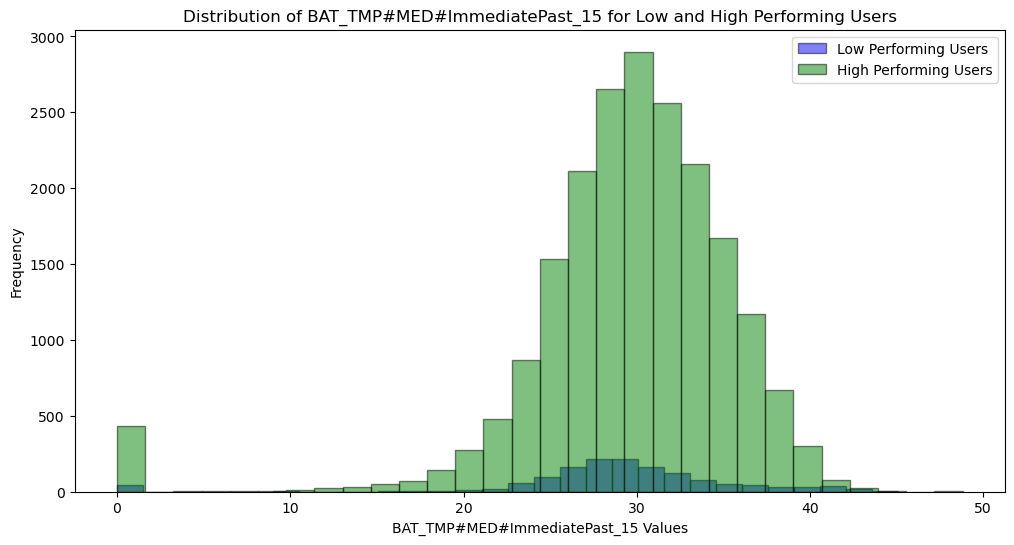

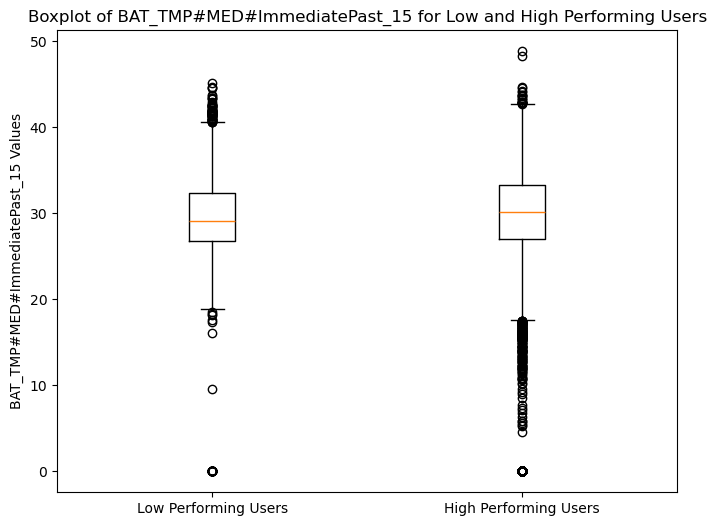

T-test results for BAT_TMP#MED#ImmediatePast_15: t-statistic = -1.8139463293649563, p-value = 0.06987648846185945
Mann-Whitney U test results for BAT_TMP#MED#ImmediatePast_15: U-statistic = 13261103.5, p-value = 2.31075638364426e-05
Pearson correlation for low-performing users: -0.10779639957286165
Pearson correlation for high-performing users: -0.1515709777704944


In [24]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Extract the feature for low and high performing users
feature_name = 'BAT_TMP#MED#ImmediatePast_15'
low_feature_values = X_low[feature_name]
high_feature_values = X_high[feature_name]

# 1. Descriptive statistics
print("Descriptive Statistics for Low Performing Users:")
print(f"Mean: {np.mean(low_feature_values)}, Median: {np.median(low_feature_values)}, Std: {np.std(low_feature_values)}, Min: {np.min(low_feature_values)}, Max: {np.max(low_feature_values)}")

print("\nDescriptive Statistics for High Performing Users:")
print(f"Mean: {np.mean(high_feature_values)}, Median: {np.median(high_feature_values)}, Std: {np.std(high_feature_values)}, Min: {np.min(high_feature_values)}, Max: {np.max(high_feature_values)}")

# 2. Visualize the distributions
plt.figure(figsize=(12, 6))
plt.hist(low_feature_values, bins=30, alpha=0.5, label='Low Performing Users', color='blue', edgecolor='black')
plt.hist(high_feature_values, bins=30, alpha=0.5, label='High Performing Users', color='green', edgecolor='black')
plt.xlabel(f"{feature_name} Values")
plt.ylabel("Frequency")
plt.title(f"Distribution of {feature_name} for Low and High Performing Users")
plt.legend()
plt.show()

# Boxplot for better visualization
plt.figure(figsize=(8, 6))
plt.boxplot([low_feature_values, high_feature_values], labels=['Low Performing Users', 'High Performing Users'])
plt.title(f"Boxplot of {feature_name} for Low and High Performing Users")
plt.ylabel(f"{feature_name} Values")
plt.show()

# 3. Statistical test (T-test or Mann-Whitney U test based on normality)
# If data is normally distributed use t-test; otherwise, Mann-Whitney U test
t_stat, p_val = stats.ttest_ind(low_feature_values, high_feature_values, equal_var=False)
print(f"T-test results for {feature_name}: t-statistic = {t_stat}, p-value = {p_val}")

# Alternatively, if not normally distributed:
u_stat, p_val_u = stats.mannwhitneyu(low_feature_values, high_feature_values)
print(f"Mann-Whitney U test results for {feature_name}: U-statistic = {u_stat}, p-value = {p_val_u}")

# 4. Correlation with the target for each group
pearson_corr_low = np.corrcoef(low_feature_values, y_low)[0, 1]
pearson_corr_high = np.corrcoef(high_feature_values, y_high)[0, 1]
print(f"Pearson correlation for low-performing users: {pearson_corr_low}")
print(f"Pearson correlation for high-performing users: {pearson_corr_high}")


Descriptive Statistics for Low Performing Users:
Mean: 1766.335693359375, Median: 1424.3948974609375, Std: 3577.8525390625, Min: 0.0, Max: 66975.1328125

Descriptive Statistics for High Performing Users:
Mean: 1595.3175048828125, Median: 1365.0244140625, Std: 2002.330078125, Min: 0.0, Max: 44371.80859375


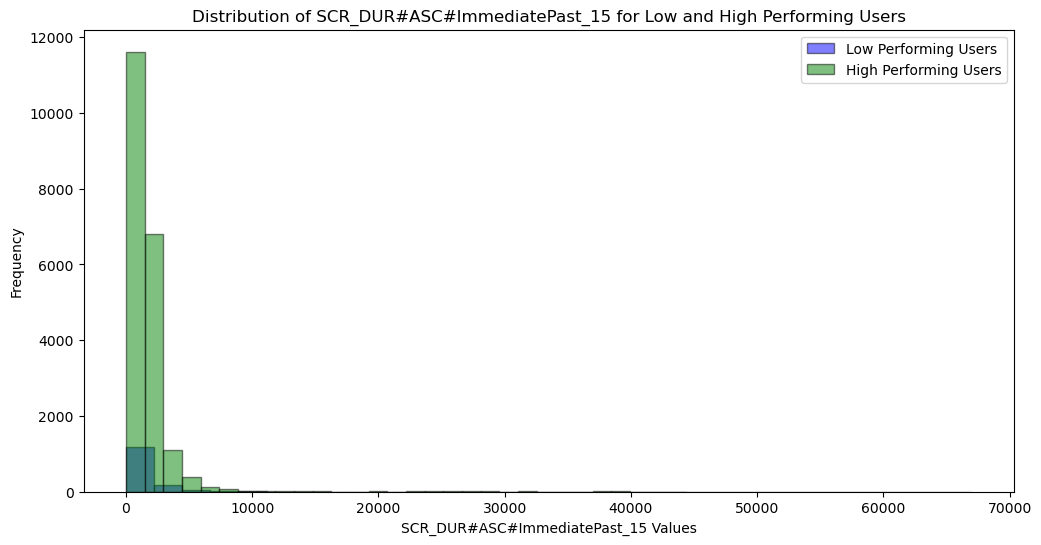

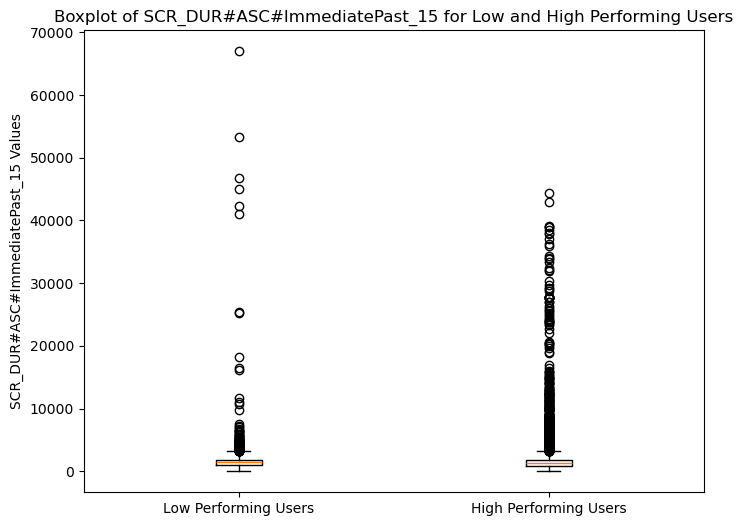

T-test results for SCR_DUR#ASC#ImmediatePast_15: t-statistic = 1.7730938485090173, p-value = 0.07642048550865377
Mann-Whitney U test results for SCR_DUR#ASC#ImmediatePast_15: U-statistic = 14452180.0, p-value = 0.3024847815317969
Pearson correlation for low-performing users: 0.008680601865805965
Pearson correlation for high-performing users: -0.027064062949530187


In [25]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Extract the feature for low and high performing users
feature_name = 'SCR_DUR#ASC#ImmediatePast_15'
low_feature_values = X_low[feature_name]
high_feature_values = X_high[feature_name]

# 1. Descriptive statistics
print("Descriptive Statistics for Low Performing Users:")
print(f"Mean: {np.mean(low_feature_values)}, Median: {np.median(low_feature_values)}, Std: {np.std(low_feature_values)}, Min: {np.min(low_feature_values)}, Max: {np.max(low_feature_values)}")

print("\nDescriptive Statistics for High Performing Users:")
print(f"Mean: {np.mean(high_feature_values)}, Median: {np.median(high_feature_values)}, Std: {np.std(high_feature_values)}, Min: {np.min(high_feature_values)}, Max: {np.max(high_feature_values)}")

# 2. Visualize the distributions
plt.figure(figsize=(12, 6))
plt.hist(low_feature_values, bins=30, alpha=0.5, label='Low Performing Users', color='blue', edgecolor='black')
plt.hist(high_feature_values, bins=30, alpha=0.5, label='High Performing Users', color='green', edgecolor='black')
plt.xlabel(f"{feature_name} Values")
plt.ylabel("Frequency")
plt.title(f"Distribution of {feature_name} for Low and High Performing Users")
plt.legend()
plt.show()

# Boxplot for better visualization
plt.figure(figsize=(8, 6))
plt.boxplot([low_feature_values, high_feature_values], labels=['Low Performing Users', 'High Performing Users'])
plt.title(f"Boxplot of {feature_name} for Low and High Performing Users")
plt.ylabel(f"{feature_name} Values")
plt.show()

# 3. Statistical test (T-test or Mann-Whitney U test based on normality)
# If data is normally distributed use t-test; otherwise, Mann-Whitney U test
t_stat, p_val = stats.ttest_ind(low_feature_values, high_feature_values, equal_var=False)
print(f"T-test results for {feature_name}: t-statistic = {t_stat}, p-value = {p_val}")

# Alternatively, if not normally distributed:
u_stat, p_val_u = stats.mannwhitneyu(low_feature_values, high_feature_values)
print(f"Mann-Whitney U test results for {feature_name}: U-statistic = {u_stat}, p-value = {p_val_u}")

# 4. Correlation with the target for each group
pearson_corr_low = np.corrcoef(low_feature_values, y_low)[0, 1]
pearson_corr_high = np.corrcoef(high_feature_values, y_high)[0, 1]
print(f"Pearson correlation for low-performing users: {pearson_corr_low}")
print(f"Pearson correlation for high-performing users: {pearson_corr_high}")

Descriptive Statistics for Low Performing Users:
Mean: 3467.07958984375, Median: 43.86800003051758, Std: 13580.77734375, Min: 1.1269999742507935, Max: 119310.765625

Descriptive Statistics for High Performing Users:
Mean: 537.2509155273438, Median: 49.11899948120117, Std: 1610.625, Min: 1.6019999980926514, Max: 44205.43359375


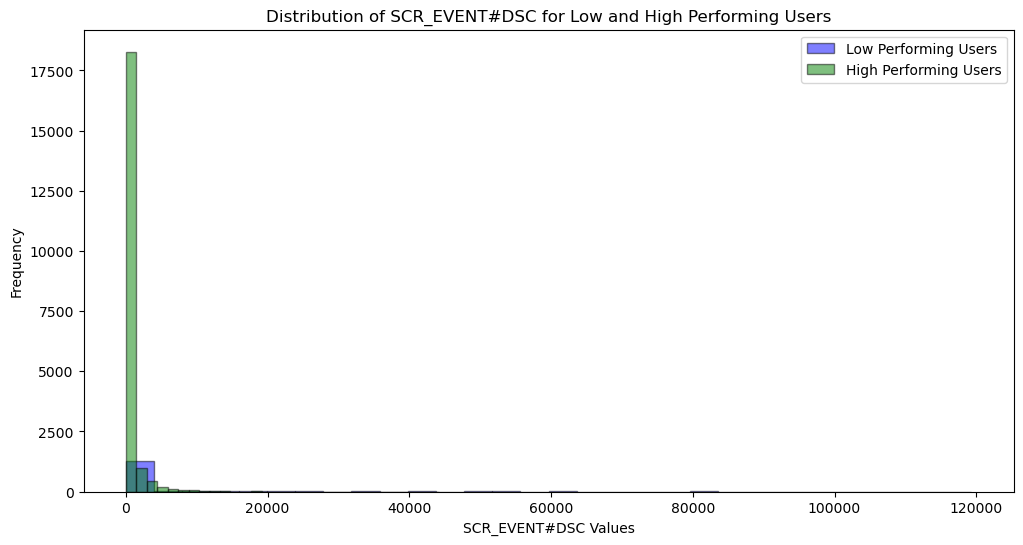

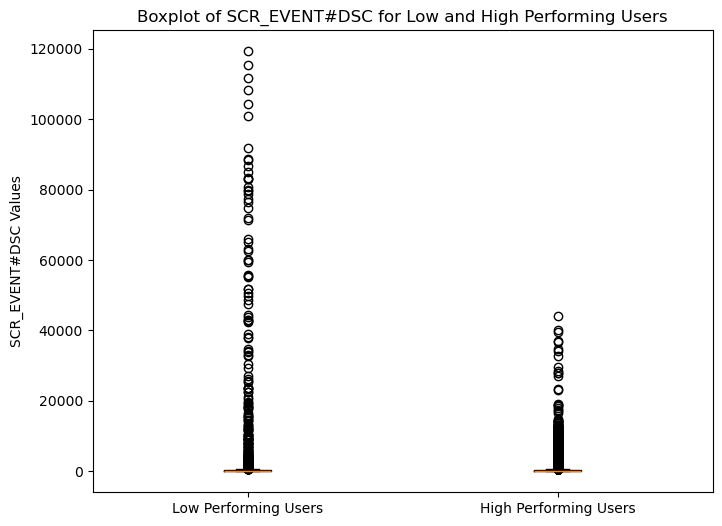

T-test results for SCR_EVENT#DSC: t-statistic = 8.085326739825602, p-value = 1.323355472684605e-15
Mann-Whitney U test results for SCR_EVENT#DSC: U-statistic = 13689877.5, p-value = 0.01937637761646724
Pearson correlation for low-performing users: -0.08951837739411726
Pearson correlation for high-performing users: -0.11986972631510309


In [26]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Extract the feature for low and high performing users
feature_name = 'SCR_EVENT#DSC'
low_feature_values = X_low[feature_name]
high_feature_values = X_high[feature_name]

# 1. Descriptive statistics
print("Descriptive Statistics for Low Performing Users:")
print(f"Mean: {np.mean(low_feature_values)}, Median: {np.median(low_feature_values)}, Std: {np.std(low_feature_values)}, Min: {np.min(low_feature_values)}, Max: {np.max(low_feature_values)}")

print("\nDescriptive Statistics for High Performing Users:")
print(f"Mean: {np.mean(high_feature_values)}, Median: {np.median(high_feature_values)}, Std: {np.std(high_feature_values)}, Min: {np.min(high_feature_values)}, Max: {np.max(high_feature_values)}")

# 2. Visualize the distributions
plt.figure(figsize=(12, 6))
plt.hist(low_feature_values, bins=30, alpha=0.5, label='Low Performing Users', color='blue', edgecolor='black')
plt.hist(high_feature_values, bins=30, alpha=0.5, label='High Performing Users', color='green', edgecolor='black')
plt.xlabel(f"{feature_name} Values")
plt.ylabel("Frequency")
plt.title(f"Distribution of {feature_name} for Low and High Performing Users")
plt.legend()
plt.show()

# Boxplot for better visualization
plt.figure(figsize=(8, 6))
plt.boxplot([low_feature_values, high_feature_values], labels=['Low Performing Users', 'High Performing Users'])
plt.title(f"Boxplot of {feature_name} for Low and High Performing Users")
plt.ylabel(f"{feature_name} Values")
plt.show()

# 3. Statistical test (T-test or Mann-Whitney U test based on normality)
# If data is normally distributed use t-test; otherwise, Mann-Whitney U test
t_stat, p_val = stats.ttest_ind(low_feature_values, high_feature_values, equal_var=False)
print(f"T-test results for {feature_name}: t-statistic = {t_stat}, p-value = {p_val}")

# Alternatively, if not normally distributed:
u_stat, p_val_u = stats.mannwhitneyu(low_feature_values, high_feature_values)
print(f"Mann-Whitney U test results for {feature_name}: U-statistic = {u_stat}, p-value = {p_val_u}")

# 4. Correlation with the target for each group
pearson_corr_low = np.corrcoef(low_feature_values, y_low)[0, 1]
pearson_corr_high = np.corrcoef(high_feature_values, y_high)[0, 1]
print(f"Pearson correlation for low-performing users: {pearson_corr_low}")
print(f"Pearson correlation for high-performing users: {pearson_corr_high}")

Descriptive Statistics for Low Performing Users:
Mean: 7.788201808929443, Median: 5.0, Std: 8.149147987365723, Min: 0.0, Max: 79.0

Descriptive Statistics for High Performing Users:
Mean: 11.182069778442383, Median: 4.0, Std: 79.51126098632812, Min: 0.0, Max: 3122.0


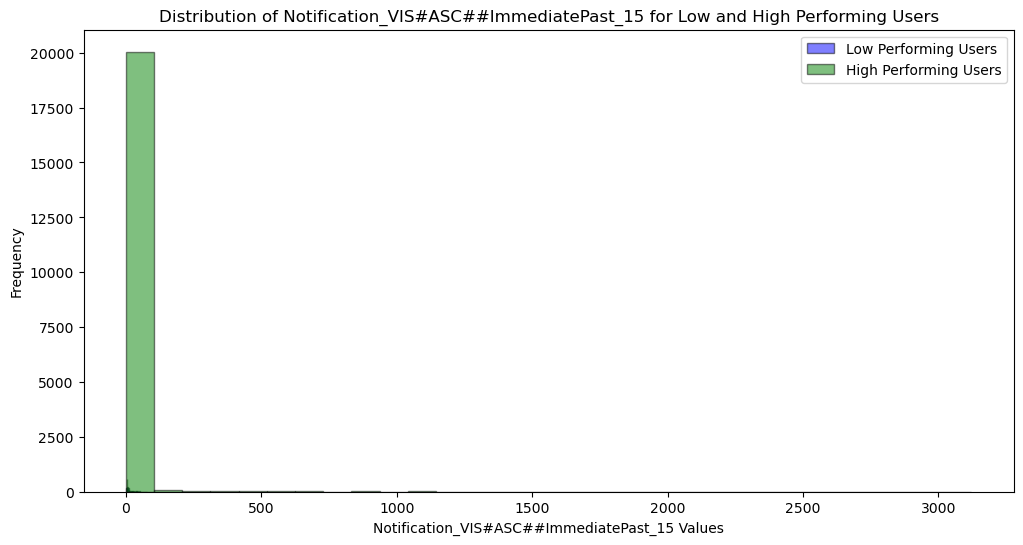

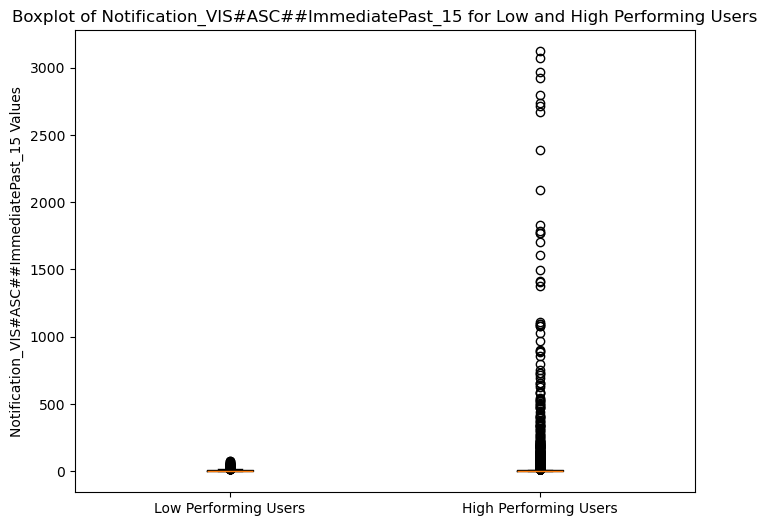

T-test results for Notification_VIS#ASC##ImmediatePast_15: t-statistic = -5.656033380436002, p-value = 1.57009976877941e-08
Mann-Whitney U test results for Notification_VIS#ASC##ImmediatePast_15: U-statistic = 16213600.0, p-value = 7.682458691376246e-19
Pearson correlation for low-performing users: 0.016105016935151126
Pearson correlation for high-performing users: 0.054027386843036526


In [27]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Extract the feature for low and high performing users
feature_name = 'Notification_VIS#ASC##ImmediatePast_15'
low_feature_values = X_low[feature_name]
high_feature_values = X_high[feature_name]

# 1. Descriptive statistics
print("Descriptive Statistics for Low Performing Users:")
print(f"Mean: {np.mean(low_feature_values)}, Median: {np.median(low_feature_values)}, Std: {np.std(low_feature_values)}, Min: {np.min(low_feature_values)}, Max: {np.max(low_feature_values)}")

print("\nDescriptive Statistics for High Performing Users:")
print(f"Mean: {np.mean(high_feature_values)}, Median: {np.median(high_feature_values)}, Std: {np.std(high_feature_values)}, Min: {np.min(high_feature_values)}, Max: {np.max(high_feature_values)}")

# 2. Visualize the distributions
plt.figure(figsize=(12, 6))
plt.hist(low_feature_values, bins=30, alpha=0.5, label='Low Performing Users', color='blue', edgecolor='black')
plt.hist(high_feature_values, bins=30, alpha=0.5, label='High Performing Users', color='green', edgecolor='black')
plt.xlabel(f"{feature_name} Values")
plt.ylabel("Frequency")
plt.title(f"Distribution of {feature_name} for Low and High Performing Users")
plt.legend()
plt.show()

# Boxplot for better visualization
plt.figure(figsize=(8, 6))
plt.boxplot([low_feature_values, high_feature_values], labels=['Low Performing Users', 'High Performing Users'])
plt.title(f"Boxplot of {feature_name} for Low and High Performing Users")
plt.ylabel(f"{feature_name} Values")
plt.show()

# 3. Statistical test (T-test or Mann-Whitney U test based on normality)
# If data is normally distributed use t-test; otherwise, Mann-Whitney U test
t_stat, p_val = stats.ttest_ind(low_feature_values, high_feature_values, equal_var=False)
print(f"T-test results for {feature_name}: t-statistic = {t_stat}, p-value = {p_val}")

# Alternatively, if not normally distributed:
u_stat, p_val_u = stats.mannwhitneyu(low_feature_values, high_feature_values)
print(f"Mann-Whitney U test results for {feature_name}: U-statistic = {u_stat}, p-value = {p_val_u}")

# 4. Correlation with the target for each group
pearson_corr_low = np.corrcoef(low_feature_values, y_low)[0, 1]
pearson_corr_high = np.corrcoef(high_feature_values, y_high)[0, 1]
print(f"Pearson correlation for low-performing users: {pearson_corr_low}")
print(f"Pearson correlation for high-performing users: {pearson_corr_high}")